In [1]:
import numpy as np
import scipy
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid", font_scale=1.3)
import folium

from camion.fca import E2SFCA
from camion.optimization import RegularOptimizer, MaxiMinOptimizer

# Load data

- Download the [polygon file](https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/894e9162-871c-4552-a09c-c6915d8783fb?view_id=2c40fce3-0bb2-46d3-bb67-04a935151a96).
- Download the [restaurants dataset](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j).


## Facilities

In [2]:
facilities = pd.read_csv("data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
facilities = facilities\
    .dropna(subset=["Latitude", "Longitude"])\
    .loc[(facilities["Latitude"] != 0) & (facilities["Longitude"] != 0)]\
    .drop_duplicates(subset="CAMIS")\
    .sample(1000)

facilities["capacity"] = np.random.randint(low=1, high=1000, size=facilities.shape[0])
facilities["join"] = 1

facilities.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,capacity,join
49733,50058997,MARCHINI RESTAURANT,Queens,54-30,48 STREET,11378.0,7183618266,Pizza,08/03/2021,Violations were cited in the following area(s).,...,40.729980,-73.919110,402.0,30.0,20500.0,4058878.0,4.025460e+09,QN31,78,1
317330,50118687,NaN,Manhattan,1663,1 AVENUE,10028.0,9174883720,NaN,01/01/1900,NaN,...,40.777238,-73.949119,108.0,5.0,14602.0,1050033.0,1.015490e+09,MN32,957,1
18464,50034192,K'OOK,Manhattan,324,EAST 6 STREET,10003.0,2122540300,Korean,01/09/2017,Violations were cited in the following area(s).,...,40.727066,-73.987780,103.0,2.0,3800.0,1006234.0,1.004470e+09,MN22,1,1
49170,50002726,TORO,Manhattan,85,10 AVENUE,10011.0,2126912360,Spanish,05/16/2018,Violations were cited in the following area(s).,...,40.743052,-74.007546,104.0,3.0,9900.0,1012277.0,1.006870e+09,MN13,430,1
171485,50103215,Hungry Ghost,Brooklyn,156,7 AVENUE,11215.0,2022706688,Coffee/Tea,10/01/2021,Violations were cited in the following area(s).,...,40.672227,-73.977141,306.0,39.0,15700.0,3020686.0,3.009660e+09,BK37,658,1


## Population locations

In [3]:
pop_locations = gpd.read_file("data/zip_code_040114.geojson")
pop_locations = pop_locations.drop_duplicates(subset="ZIPCODE")
pop_locations["POPULATION_DENSITY"] = pop_locations["POPULATION"] / pop_locations["AREA"]
pop_locations["geometry_centroid"] = pop_locations["geometry"].apply(lambda r: r.centroid)
pop_locations["Longitude"] = pop_locations["geometry_centroid"].apply(lambda r: r.x)
pop_locations["Latitude"] = pop_locations["geometry_centroid"].apply(lambda r: r.y)
pop_locations["join"] = 1

pop_locations.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,POPULATION_DENSITY,geometry_centroid,Longitude,Latitude,join
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",0.000823,POINT (-73.79650 40.67587),-73.796503,40.675872,1
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679...",0.002107,POINT (-73.93633 40.67116),-73.936327,40.671156,1
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668...",0.001998,POINT (-73.91308 40.66281),-73.913077,40.662813,1
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670...",0.002385,POINT (-73.95396 40.66311),-73.953960,40.663115,1
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650...",0.001960,POINT (-73.97645 40.64332),-73.976451,40.643320,1


## Distance matrix

In [4]:
distance_matrix = pd.merge(
    pop_locations[["ZIPCODE", "Latitude", "Longitude", "join"]],
    facilities[["CAMIS", "Latitude", "Longitude", "join"]],
    on="join",
    suffixes=["_pop", "_facility"]
)

In [5]:
%%time

# Compute geodesic (straight) distance
distance_matrix["geodesic_distance"] = distance_matrix.apply(lambda r: geodesic([r["Latitude_pop"], r["Longitude_pop"]],
                                                                                [r["Latitude_facility"], r["Longitude_facility"]]).km,
                                                             axis=1)

CPU times: user 44.6 s, sys: 128 ms, total: 44.7 s
Wall time: 44.9 s


In [6]:
distance_matrix.head()

,ZIPCODE,Latitude_pop,Longitude_pop,join,CAMIS,Latitude_facility,Longitude_facility,geodesic_distance
0,11436,40.675872,-73.796503,1,50058997,40.729980,-73.919110,11.977904
1,11436,40.675872,-73.796503,1,50118687,40.777238,-73.949119,17.115662
2,11436,40.675872,-73.796503,1,50034192,40.727066,-73.987780,17.136019
3,11436,40.675872,-73.796503,1,50002726,40.743052,-74.007546,19.331379
4,11436,40.675872,-73.796503,1,50103215,40.672227,-73.977141,15.278004


# Accessibility computation

## Convert dataframes to matrices

In [7]:
distance_matrix_pivot = distance_matrix.pivot_table(
    index="ZIPCODE",
    columns="CAMIS",
    values="geodesic_distance"
)

# reorder rows & columns
distance_matrix_pivot = distance_matrix_pivot.reindex(pop_locations["ZIPCODE"])
distance_matrix_pivot = distance_matrix_pivot[facilities["CAMIS"]]

assert all(distance_matrix_pivot.index == pop_locations["ZIPCODE"])
assert all(distance_matrix_pivot.columns == facilities["CAMIS"])

In [8]:
D_ij = distance_matrix_pivot.values
P_i = pop_locations["POPULATION"].values.reshape(1, -1)
S_j = facilities["capacity"].values.reshape(1, -1)

## Floating catchment area

In [9]:
weights = [(5, 1), (10, 0.42), (20, 0.09)]

In [10]:
e2sfca = E2SFCA(S_j, P_i, D_ij)
W_ij = e2sfca.compute_weighted_distances(weights)
A_i = e2sfca.compute_accessibility_score(weights)

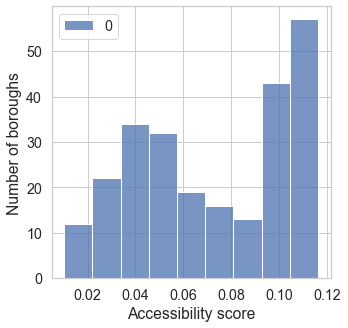

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

ax = sns.histplot(A_i)
ax.set_xlabel("Accessibility score")
ax.set_ylabel("Number of boroughs")

plt.show()

In [12]:
# Save accessibility
pop_locations["A_i"] = A_i

# Accessibility Optimization

In [13]:
budget = 10000
growth_percentage = 0.2

## Regular Optimization

In [14]:
regular_optimizer = RegularOptimizer()

In [15]:
# Run optimization
S_j_new_regular = regular_optimizer.run_optimization(S_j, P_i, W_ij, budget, growth_percentage)

In [17]:
# Compute new accessibility
e2sfca_optim_regular = E2SFCA(S_j_new_regular, P_i, D_ij)
A_i_new_regular = e2sfca_optim_regular.compute_accessibility_score(weights)

## Maxi-min optimization

In [18]:
maximin_optimizer = MaxiMinOptimizer()

In [19]:
# Run optimization
S_j_new_maximin = maximin_optimizer.run_optimization(S_j, P_i, W_ij, budget, growth_percentage)

In [20]:
# Compute new accessibility
e2sfca_optim_maximin = E2SFCA(S_j_new_maximin, P_i, D_ij)
A_i_new_maximin = e2sfca_optim_maximin.compute_accessibility_score(weights)

## Save results

In [21]:
# Regular optimization
pop_locations["A_i_new_regular"] = A_i_new_regular
pop_locations["A_i_delta_regular"] = pop_locations["A_i_new_regular"] - pop_locations["A_i"]

# Maximin optimization
pop_locations["A_i_new_maximin"] = A_i_new_maximin
pop_locations["A_i_delta_maximin"] = pop_locations["A_i_new_maximin"] - pop_locations["A_i"]

In [22]:
# Regular optimization
facilities["capacity_new_regular"] = S_j_new_regular
facilities["capacity_delta_regular"] = facilities["capacity_new_regular"] - facilities["capacity"]

# Maximin optimization
facilities["capacity_new_maximin"] = S_j_new_maximin
facilities["capacity_delta_maximin"] = facilities["capacity_new_maximin"] - facilities["capacity"]

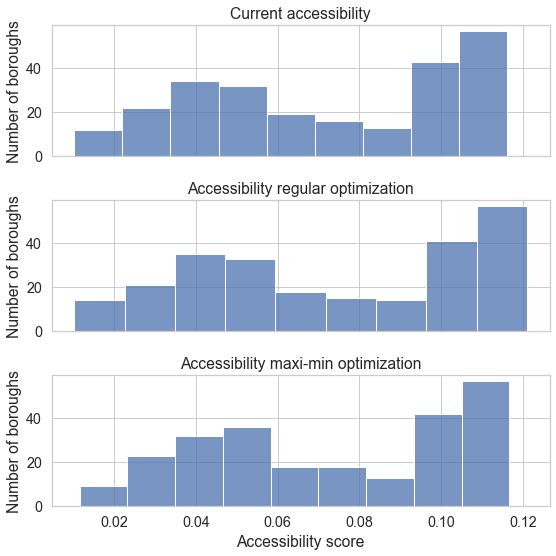

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex=True, sharey=True)

# Subplot 1
sns.histplot(
    data=pop_locations,
    x="A_i",
    ax=axs[0]
)

axs[0].set_title("Current accessibility")
axs[0].set_xlabel("Accessibility score")
axs[0].set_ylabel("Number of boroughs")

# Subplot 2
sns.histplot(
    data=pop_locations,
    x="A_i_new_regular",
    ax=axs[1]
)

axs[1].set_title("Accessibility regular optimization")
axs[1].set_xlabel("Accessibility score")
axs[1].set_ylabel("Number of boroughs")

# Subplot 3
sns.histplot(
    data=pop_locations,
    x="A_i_new_maximin",
    ax=axs[2]
)

axs[2].set_title("Accessibility maxi-min optimization")
axs[2].set_xlabel("Accessibility score")
axs[2].set_ylabel("Number of boroughs")

plt.tight_layout()
plt.show()

# Interactive map

In [24]:
# Init map
interactive_map = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=12,
    tiles="cartodbpositron"
)

# Add population
folium.Choropleth(
    name="Population density",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "POPULATION_DENSITY"],
    key_on="feature.id",
    fill_color="YlGnBu",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility, before optimization
folium.Choropleth(
    name="Accessibility score, before optimization",
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i"],
    key_on="feature.id",
    fill_color="YlGn",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility delta, after regular optimization
folium.Choropleth(
    name="Accessibility delta, after regular optimization",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i_delta_regular"],
    key_on="feature.id",
    fill_color="Purples",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add accessibility delta, after maxi-min optimization
folium.Choropleth(
    name="Accessibility delta, after maxi-min optimization",
    show=False,
    geo_data=pop_locations[["ZIPCODE", "geometry"]].set_index("ZIPCODE"),
    data=pop_locations,
    columns=["ZIPCODE", "A_i_delta_maximin"],
    key_on="feature.id",
    fill_color="Purples",
    line_opacity=0.05,
    fill_opacity=0.5,
).add_to(interactive_map)

# Add facilities
for _, row in facilities.iterrows():   
    folium.Marker(
        name="Facilities",
        show=True,
        location=(row["Latitude"], row["Longitude"]),
        popup="{0} ({1})".format(
            row["DBA"],
            row["CUISINE DESCRIPTION"]
        ),
        icon=folium.DivIcon(html="""
            <div><svg>
                <rect width="{0}"
                      height="{0}"
                      fill="{1}"
                      opacity=".8"
                      stroke="black"
                      stroke-width=".5"
                />
            </svg></div>
            """.format(row["capacity"] / 100, "#fee6ce")
        )
    ).add_to(interactive_map)

# Add LayerControl
folium.LayerControl().add_to(interactive_map)
    
# Save map
interactive_map.save("/Users/eric/Desktop/map.html")

/usr/local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
